In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
from tqdm import trange
import pandas as pd

In [2]:
sys.path.append('/home/raffaele/Documents/ml-project/src/')

In [3]:
from torch_utility import *

## Import Dataset

In [4]:
data = np.genfromtxt('/home/raffaele/Documents/ml-project/cup/ML-CUP20-TR.csv', delimiter=',', dtype=np.float32)
X = data[:, 1:-2]
y = data[:, -2:]

In [5]:
print(X.shape)
print(y.shape)

(1524, 10)
(1524, 2)


### Split train set and Validation Set

In [6]:
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42)

In [7]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)

(1219, 10)
(1219, 2)
(305, 10)
(305, 2)


In [8]:
Xtrain = Xtrain.astype('float32')
ytrain = ytrain.astype('float32')

Xval = Xval.astype('float32')
yval = yval.astype('float32')

## Define Models

In [9]:
class Net(nn.Module):

    def __init__(self, num_units1, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
#         self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units1,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
#         x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [10]:
net = Net(50, torch.relu)
print(net)

Net(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
)


### Initialize the weights

In [11]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
        
net.apply(init_weights)

Net(
  (input_layer): Linear(in_features=10, out_features=50, bias=True)
  (output): Linear(in_features=50, out_features=2, bias=True)
)

In [12]:
# def MEE(y_real, y_pred): 
#     return torch.div(torch.sum(F.pairwise_distance(y_real, y_pred, p=2)), len(y_real))

In [13]:
class MEE(torch.nn.Module):

    def __init__(self):
        super(MEE, self).__init__()

    def forward(self, y_true, y_pred):
#         return torch.mean(torch.linalg.norm(y_pred - y_true))
#         return torch.mean(torch.cdist(y_true, y_pred, p=2))
        return torch.div(torch.sum(torch.pairwise_distance(y_true, y_pred)), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true, ord=None), len(y_true))
#         return torch.div(torch.linalg.norm(y_pred - y_true), len(y_true))

In [14]:
from sklearn.metrics import euclidean_distances

def mean_euclidean_error(y_true, y_pred):
    assert y_true.shape == y_pred.shape
#     return np.mean(np.linalg.norm(y_pred - y_true))
#     return np.divide(np.linalg.norm(y - y_real), len(y_real))
#     return np.mean(euclidean_distances(y_true, y_pred))
    return np.mean(np.linalg.norm(y_true - y_pred, axis=1)) #utilizzare questa loss la prossima grid

In [15]:
from skorch import NeuralNetRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from skorch.callbacks import EarlyStopping

Network = NeuralNetRegressor(net, verbose=0, callbacks=[EarlyStopping(patience=100)])

params = {
    'max_epochs':[1000],
    'module__activation':[torch.relu],
    'module__num_units1' :[50, 75, 100],
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [64],
    'criterion' : [MEE],
    'optimizer': [optim.SGD],
    'optimizer__weight_decay': [0.0001, 0.00001, 0.001, 0.00005],
    'optimizer__momentum': [0.7, 0.8, 0.9],
    'optimizer__nesterov':[True],
}

neg_mean_euclidean_error = make_scorer(mean_euclidean_error, greater_is_better=False)
# The grid search module is instantiated
gs = GridSearchCV(Network, params,
                  refit=False,
                  scoring=neg_mean_euclidean_error,
                  cv=3,
                  return_train_score=True,
                  n_jobs=3,
                  verbose=2)
# Initialize grid search
gs.fit(Xtrain, ytrain)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


KeyboardInterrupt: 

In [122]:
df = pd.DataFrame(gs.cv_results_)[['param_module__num_units1',
#                                    'param_module__num_units2',
                                   'param_batch_size',
                                   'param_module__activation',
                                   'param_lr', 
                                     'param_max_epochs', 'param_optimizer','param_optimizer__weight_decay',
                                   'param_optimizer__momentum', 
                                   'param_optimizer__nesterov',
                                     'mean_train_score', 'mean_test_score', 
                                   'std_train_score','mean_fit_time','std_fit_time',
                                     'rank_test_score']].sort_values(by='rank_test_score')
df.rename(columns={'param_module__num_units1': '#Units1',
#                    'param_module__num_units2': '#Units2',
                   'param_max_epochs': 'max_epochs',
                   'param_lr': 'lr',
                   'param_module__activation': 'activation',
                   'param_batch_size': 'batch_size',
                   'param_optimizer': 'optimizer',
                   'param_optimizer__momentum': 'momentum',
                   'param_optimizer__nesterov':'nesterov',
                   'param_optimizer__weight_decay': 'weight_decay',
                   'std_train_score' : 'std_train_score',
                   'mean_test_score': 'mean_val_score',
                   'rank_test_score': 'rank_val_score'}, inplace=True)
df.mean_train_score *= -1
df.mean_val_score *= -1

def highlight_equal(s, value, column):
    is_max = pd.Series(data=False, index=s.index)
    is_max[column] = s.loc[column] == value
    return ['background-color: lightyellow' if is_max.any() else '' for v in is_max]

df.head(30).style.apply(highlight_equal, value=1, 
                        column=['rank_val_score'], axis=1).hide_index()

#Units1,batch_size,activation,lr,max_epochs,optimizer,weight_decay,momentum,nesterov,mean_train_score,mean_val_score,std_train_score,mean_fit_time,std_fit_time,rank_val_score
50,64,,0.006000,1000,,0.000600,0.900000,True,2.518564,2.897166,0.051413,55.525440,14.454862,1
75,64,,0.010000,1000,,0.000100,0.800000,True,2.552109,2.906147,0.059615,54.738617,9.972375,2
75,64,,0.010000,1000,,0.000300,0.800000,True,2.577484,2.909380,0.055410,50.804795,16.248909,3
50,64,,0.010000,1000,,0.000300,0.900000,True,2.475767,2.910451,0.057379,27.281302,12.196977,4
50,64,,0.006000,1000,,0.000300,0.900000,True,2.503532,2.910924,0.096406,48.003039,15.463717,5
75,64,,0.006000,1000,,0.000010,0.900000,True,2.546872,2.913977,0.122980,40.034772,19.720087,6
100,64,,0.010000,1000,,0.000100,0.800000,True,2.558659,2.916010,0.057457,52.571050,16.053093,7
100,64,,0.006000,1000,,0.000100,0.900000,True,2.515997,2.917110,0.074223,50.140725,10.168286,8
50,64,,0.006000,1000,,0.000010,0.900000,True,2.526639,2.921485,0.057292,37.110491,10.528239,9
100,64,,0.010000,1000,,0.000010,0.900000,True,2.445141,2.921801,0.073664,28.450599,8.022683,10


In [123]:
df.to_csv('../../grid_results/gridSearch_prova.csv', index=False)

In [124]:
gs.param_grid

{'max_epochs': [1000],
 'module__activation': [<function _VariableFunctionsClass.relu>,
  <function _VariableFunctionsClass.tanh>,
  <function _VariableFunctionsClass.sigmoid>],
 'module__num_units1': [50, 75, 100],
 'lr': [0.01, 0.006, 0.03],
 'batch_size': [64],
 'criterion': [__main__.MEE],
 'optimizer': [torch.optim.sgd.SGD],
 'optimizer__weight_decay': [0.0001, 1e-05, 0.0003, 0.0006],
 'optimizer__momentum': [0.7, 0.8, 0.9],
 'optimizer__nesterov': [True]}

In [154]:
Network.get_params().keys()

dict_keys(['module', 'criterion', 'optimizer', 'lr', 'max_epochs', 'batch_size', 'iterator_train', 'iterator_valid', 'dataset', 'train_split', 'callbacks', 'predict_nonlinearity', 'warm_start', 'verbose', 'device', 'callbacks__epoch_timer', 'callbacks__train_loss', 'callbacks__train_loss__name', 'callbacks__train_loss__lower_is_better', 'callbacks__train_loss__on_train', 'callbacks__valid_loss', 'callbacks__valid_loss__name', 'callbacks__valid_loss__lower_is_better', 'callbacks__valid_loss__on_train', 'callbacks__print_log', 'callbacks__print_log__keys_ignored', 'callbacks__print_log__sink', 'callbacks__print_log__tablefmt', 'callbacks__print_log__floatfmt', 'callbacks__print_log__stralign'])

In [155]:
print(gs.best_params_)

{'batch_size': 64, 'criterion': <class '__main__.MEE'>, 'lr': 0.001, 'max_epochs': 300, 'module__num_units1': 50, 'module__num_units2': 30, 'optimizer': <class 'torch.optim.sgd.SGD'>, 'optimizer__momentum': 0.8, 'optimizer__weight_decay': 0.0001}


In [156]:
gs.best_score_

-3.2546486854553223

In [104]:
from skorch import NeuralNetRegressor
test_net = Net(100, 50, torch.relu)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.06,
                          batch_size=32,
                          optimizer=optim.SGD,
                          optimizer__momentum=0.8,
                          optimizer__weight_decay=0.00001,
                          optimizer__nesterov = True,
                          criterion=torch.nn.MSELoss)
# Training
nett.fit(Xtrain, ytrain)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x50 and 100x2)

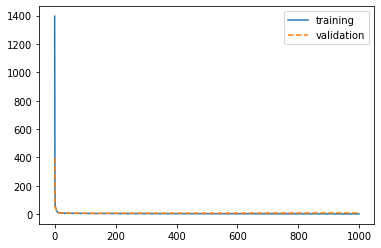

In [183]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.legend()
plt.show()

In [184]:
prova = nett.predict(Xval)

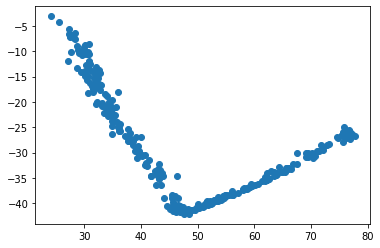

In [185]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

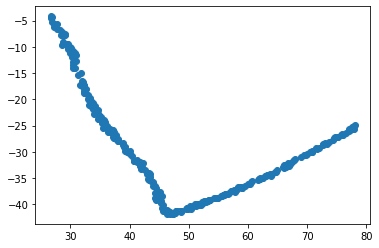

In [186]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [187]:
mean_euclidean_error(prova, yval)

3.4315946

In [16]:
class Net(nn.Module):

    def __init__(self, num_units1, num_units2, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
        self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units2,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [17]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

total = []
for i in range(0,10):
    test_net = Net(100, 50, torch.sigmoid)
    nett = NeuralNetRegressor(test_net, max_epochs=1000,
                              lr=0.006,
                              batch_size=64,
                              optimizer=optim.SGD,
                              optimizer__momentum=0.8,
                              optimizer__weight_decay=0.0001,
                              optimizer__nesterov = True,
                              criterion=MEE,
    #                           callbacks=[EarlyStopping(patience=100)]
                             )
    # Training
    nett.fit(Xtrain, ytrain)

    prova = nett.predict(Xval)
    ris = mean_euclidean_error(prova, yval)
    total.append(ris)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       49.0143       35.3226  0.3962
      2       29.0764       18.8502  0.0620
      3       14.7383        8.7788  0.0861
      4        8.6291        8.2546  0.0529
      5        8.3399        7.9905  0.0617
      6        8.0977        7.7373  0.0649
      7        7.8446        7.4690  0.0671
      8        7.5645        7.1721  0.0641
      9        7.2468        6.8391  0.0646
     10        6.8943        6.4820  0.0607
     11        6.5256        6.1255  0.0632
     12        6.1690        5.8074  0.0589
     13        5.8587        5.5540  0.1022
     14        5.6095        5.3713  0.0706
     15        5.4273        5.2634  0.0625
     16        5.2998        5.2014  0.0713
     17        5.2117        5.1622  0.0736
     18        5.1464        5.1335  0.0662
     19        5.0959        5.1092  0.0733
     20        5.0510        5.0859  0.0645
     21        5.0093        5.0

     39        4.3477        4.5109  0.0797
     40        4.3207        4.4844  0.0535
     41        4.2942        4.4581  0.0623
     42        4.2682        4.4321  0.0782
     43        4.2428        4.4064  0.0610
     44        4.2179        4.3810  0.0576
     45        4.1936        4.3559  0.0720
     46        4.1698        4.3311  0.0590
     47        4.1464        4.3069  0.0410
     48        4.1236        4.2836  0.0675
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       48.2880       34.5312  0.0488
      2       28.2861       18.1325  0.0662
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       49.0054       35.6493  0.0381
      2       29.2637       18.6839  0.0576
      3       14.5433        8.7143  0.0681
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       49.1625       35.8459  0.0666
      2       29.8195       19.6

In [227]:
total

[3.0724862,
 7.8159347,
 21.600214,
 29.726019,
 21.269506,
 19.57548,
 17.090656,
 17.473583,
 17.803865,
 21.654264]

In [228]:
np.mean(total)

17.7082

In [229]:
np.std(total)

7.098052

In [230]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
plt.ylim(2,10)
plt.xlim(0,1000)
plt.legend()
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [157]:
prova = nett.predict(Xval)

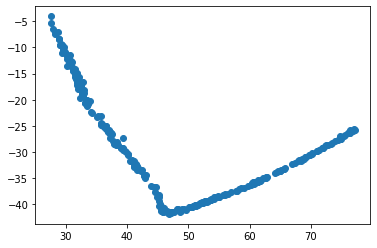

In [158]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

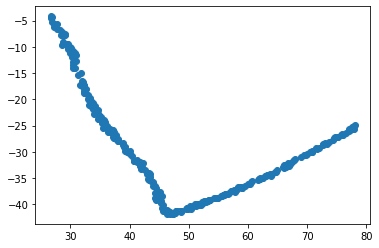

In [159]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [160]:
mean_euclidean_error(prova, yval)

3.0030868

In [18]:
class Net(nn.Module):

    def __init__(self, num_units1, activation):
        super(Net, self).__init__()
        self.activation = activation
        self.input_layer = nn.Linear(10,num_units1)
#         self.hidden1 = nn.Linear(num_units1, num_units2)
        self.output = nn.Linear(num_units1,2)

    def forward(self, x):
        x = self.activation(self.input_layer(x))
#         x = self.activation(self.hidden1(x))
        x = self.output(x)
        return x

In [46]:
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping

test_net = Net(50, torch.relu)
test_net.apply(init_weights)
nett = NeuralNetRegressor(test_net, max_epochs=1000,
                          lr=0.06,
                          batch_size=32,
                          optimizer=optim.SGD,
#                           optimizer__momentum=0.9,
#                           optimizer__weight_decay=0.00001,
#                           optimizer__nesterov = True,
                          criterion=MEE,
#                           callbacks=[EarlyStopping(patience=100)]
                         )
# Training
nett.fit(Xtrain, ytrain)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       42.9186       16.6462  0.0494
      2       11.7991        8.2703  0.0490
      3        7.7718        7.2607  0.0464
      4        6.7409        6.5313  0.0470
      5        6.0792        5.7320  0.0464
      6        5.5874        6.3514  0.0467
      7        5.4027        6.6057  0.0430
      8        5.4773        5.5469  0.0438
      9        5.3869        5.2234  0.0464
     10        5.2628        6.3155  0.0473
     11        5.1402        6.2599  0.0475
     12        5.2018        5.2903  0.0453
     13        5.0501        6.1730  0.0457
     14        5.0447        6.1013  0.0462
     15        5.0596        5.5473  0.0471
     16        4.9860        5.9078  0.0479
     17        4.9676        5.4566  0.0485
     18        4.8521        5.3663  0.0450
     19        4.8281        5.1235  0.0475
     20        4.8147        4.9637  0.0449
     21        4.7603        5.0

    174        4.3421        3.9410  0.0467
    175        4.2581        5.0111  0.0471
    176        4.2629        5.0294  0.0460
    177        4.3468        3.9363  0.0448
    178        4.2885        4.9668  0.0453
    179        4.3332        3.9518  0.0466
    180        4.0862        5.0784  0.0485
    181        4.3312        3.9810  0.0486
    182        4.1876        3.9366  0.0488
    183        4.1866        4.9726  0.0442
    184        4.1611        4.4413  0.0473
    185        4.3048        4.0640  0.0536
    186        4.2863        4.9316  0.0471
    187        4.2827        3.9689  0.0504
    188        4.2774        4.9319  0.0502
    189        4.3005        4.2630  0.0474
    190        4.1715        4.9906  0.0437
    191        4.2704        3.9634  0.0457
    192        4.1919        5.0589  0.0465
    193        4.3027        3.9579  0.0500
    194        4.2182        4.9285  0.0480
    195        4.1980        5.0636  0.0463
    196        4.2176        4.7

    359        3.9478        4.2373  0.0519
    360        3.8930        3.7512  0.0462
    361        3.9380        3.7954  0.0473
    362        3.9345        4.0302  0.0482
    363        3.9833        4.6895  0.0464
    364        3.7164        4.4219  0.0451
    365        3.9381        4.0060  0.0452
    366        3.8784        4.5487  0.0444
    367        3.9205        4.2261  0.0461
    368        3.8260        3.7757  0.0454
    369        3.9188        4.0193  0.0509
    370        3.7638        4.8407  0.0566
    371        3.9880        4.1700  0.0500
    372        3.9784        4.6253  0.0523
    373        3.9359        4.7272  0.0476
    374        3.9069        3.8106  0.0521
    375        3.8960        3.9173  0.0480
    376        3.9216        4.6783  0.0486
    377        3.8763        4.6890  0.0485
    378        3.8620        3.8088  0.0502
    379        3.9226        3.9505  0.0497
    380        3.8748        4.6572  0.0528
    381        3.8715        3.8

    543        3.6661        4.1572  0.0490
    544        3.4892        4.2604  0.0491
    545        3.6732        3.9635  0.0485
    546        3.7126        4.8670  0.0511
    547        3.8001        4.8525  0.0549
    548        3.6543        3.8105  0.0482
    549        3.6933        4.0484  0.0516
    550        3.3772        5.6147  0.0465
    551        3.7642        4.1628  0.0561
    552        3.4534        5.4454  0.0459
    553        3.6994        4.2019  0.0493
    554        3.6058        4.1830  0.0480
    555        3.6567        4.8727  0.0542
    556        3.6999        3.8928  0.0461
    557        3.6556        3.9849  0.0478
    558        3.6662        4.8121  0.0505
    559        3.6857        3.8144  0.0440
    560        3.5494        3.7978  0.0455
    561        3.6774        4.1299  0.0458
    562        3.6845        4.8473  0.0495
    563        3.6543        4.1138  0.0478
    564        3.5805        4.2074  0.0449
    565        3.7155        3.9

    729        3.3998        4.7989  0.0589
    730        3.5060        3.6294  0.0569
    731        3.4802        4.1899  0.0447
    732        3.5127        4.9046  0.0470
    733        3.4534        3.8386  0.0495
    734        3.4965        3.6905  0.0514
    735        3.4778        4.0277  0.0513
    736        3.5754        4.8081  0.0506
    737        3.5309        3.9085  0.0486
    738        3.5259        4.8673  0.0500
    739        3.4294        3.7211  0.0539
    740        3.5241        4.7735  0.0493
    741        3.5300        3.7220  0.0473
    742        3.4378        4.0247  0.0440
    743        3.4979        4.8168  0.0532
    744        3.5213        3.6114  0.0465
    745        3.4986        4.7630  0.0491
    746        3.5166        3.8041  0.0485
    747        3.4878        4.7693  0.0446
    748        3.5177        4.7660  0.0471
    749        3.5070        4.8692  0.0469
    750        3.5742        4.8587  0.0466
    751        3.4626        3.9

    913        3.4249        3.8784  0.0446
    914        3.2503        4.7505  0.0479
    915        3.2642        4.7642  0.0496
    916        3.3251        4.7555  0.0490
    917        3.2855        3.7201  0.0477
    918        3.1849        4.7398  0.0485
    919        3.2560        4.7237  0.0462
    920        3.3533        4.7938  0.0474
    921        3.2691        4.6567  0.0492
    922        3.3522        3.6593  0.0477
    923        3.3617        3.9442  0.0490
    924        3.1566        3.7828  0.0462
    925        3.2945        3.8255  0.0442
    926        3.4014        3.8060  0.0491
    927        3.2609        4.7802  0.0501
    928        3.2838        4.2487  0.0498
    929        3.2400        4.7531  0.0486
    930        3.4259        3.9085  0.0539
    931        3.3058        3.9462  0.0434
    932        3.2253        4.7307  0.0462
    933        3.4502        3.9800  0.0493
    934        3.3066        3.9871  0.0440
    935        3.2672        4.8

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Net(
    (input_layer): Linear(in_features=10, out_features=50, bias=True)
    (output): Linear(in_features=50, out_features=2, bias=True)
  ),
)

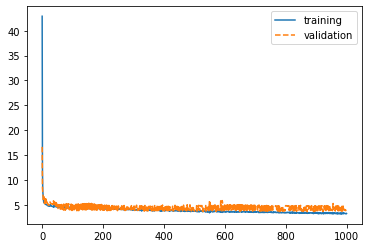

In [48]:
train_loss = nett.history[:, 'train_loss']
valid_loss = nett.history[:, 'valid_loss']

plt.plot(train_loss, '-', label='training')
plt.plot(valid_loss, '--', label='validation')
# plt.ylim(0,10)
# plt.xlim(20,1000)
plt.legend()
plt.show()

In [25]:
prova = nett.predict(Xval)

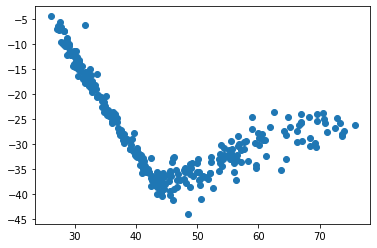

In [26]:
x1 = prova[:,0]
y1 = prova[:,1]
plt.scatter(x1, y1)

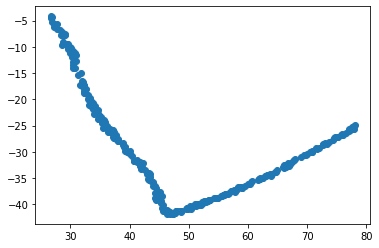

In [127]:
x_real = yval[:,0]
y_real = yval[:,1]
plt.scatter(x_real, y_real)

In [128]:
mean_euclidean_error(prova, yval)

3.286791